In [4]:
# MIT License
#
#@title Copyright (c) 2021 CCAI Community Authors { display-mode: "form" }
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# **Tutorial on Building Fast Emulators in Climate Modeling**

Authors:

*   Björn Lütjens, MIT EAPS, lutjens@mit.edu
*   Lea M. Hadzic, Stanford University
*   Mark Veillette, MIT Lincoln Laboratory

Advisors:
*   Duncan Watson-Parris, UC San Diego
*   Dava Newman, MIT Media Lab
*   Raffaele Ferrari, MIT EAPS
*   Noelle Selin, MIT IDSS

Climate models are essential in policy making. Ideally, policy makers would like to interact with climate models through quick 'what-if' questions. For example, 'what-if we plant one trillion trees' or 'what if we support carbon tax'. However, current climate models need supercomputers and are overall too impractical to give quick answers. The below TEDx video goes into more detail. 

This tutorial will teach machine learning (ML) practitioners and Earth scientists about a possible solution: fast approximations of climate models. We call those approximations 'emulators'. For the ML community, we introduce the in-/output dimensions, how to access data, the strength of a linear baseline, and common evaluation protocols for getting started with climate emulation. For the Earth scientist, we highlight key learnings in picking the functional form that ML shall learn, the need for non-ML baselines, and the risk of overfitting to internal variability.

***How Machine Learning can Empower Local Climate Voices* | Björn Lütjens | TEDxBoston**

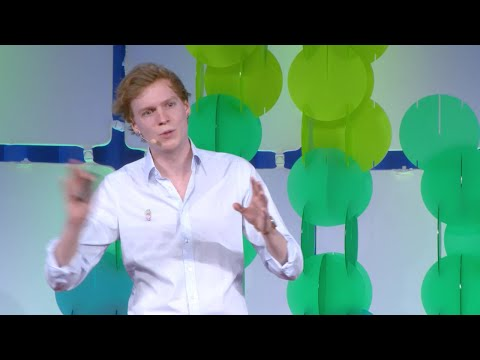

In [5]:
from IPython.display import YouTubeVideo
YouTubeVideo('DTX8SvdtrmU')

# Introduction

## Table of Contents

*   [Introduction](#Introduction)
    *   [Climate Impact](#Climate-emulators-empower-local-climate-voices)
    *   [Target Audience and Prerequisites](#Target-Audience,-Background,-and-Prerequisites)
    *   [Installation](#Installation)
*   [Data](#data)
    *   [Downloading Climate Model Data](#data-description)
    *   [Data Processing](#data-processing)
    *   [Data Visualization]()
*   [Methodology](#methodology)
    *   [Linear Emulators]()
    *   [Machine Learning-based Emulators]()
*   [Results](#results-and-discussion)
    *   [Discussion & Next steps]()
*   [References](#references)


## Climate emulators empower local climate voices

Rapid climate emulators are already used by policy and decision makers to learn about the impact of climate policies. For example, the [en-roads simulation](https://en-roads.climateinteractive.org/) below lets us rapidly explore the impact of reducing deforestation onto global temperature. However, it's unclear how global mean temperature relates to impacts at the state or city level. In this tutorial, we create an emulator that fills this gap. 

![SegmentLocal](docs/figures/tutorial/en-roads.gif "segment")a

To our ML scientist: This rapid exploration of climate policies is not possible with current global climate models due to their computational complexity. The crux of the computational complexity is that the underlying differential equations have to be solved for every scenario or parameter update from scratch. Machine learning (ML) promises a paradigm shift: the idea behind ML-based ‘*emulators*’ is to train ML models on large databases of simulated data. After training, the model will have memorized how to solve the differential equations and can be quickly run again for new parameter updates.

In the Earth Sciences, ML-based emulators have attracted a lot of attention by [predicting weather in seconds rather than hours](https://doi.org/10.1126/science.adi2336), but it is an open research question if the same will work on the much longer time scales of climate modeling. This tutorial will show that large-scale ML models are likely an overkill for emulating average temperatures and better used for more complex relationship.

<!-- and in machine learning due to challenges in physical structure, high-dimensionality, and long-term stability. While there exists tutorials for emulating the weather (Pathak et al., 2022), emulating the climate poses different challenges. Specifically, physical-consistency and long-term stability are fundamental in developing emulators that have to extrapolate multiple years beyond the data they have been trained on.-->

<!-- Modeling the possible outcomes of anthropogenic drivers of climate change, including its impacts on society and ecosystems, is important for decision makers to define adequate and effective adaptation and mitigation measures. Since a multitude of different emission pathways compatible with the Paris agreement exist, they critically rely on climate models to be able to understand climate change and climate policies. Most climate models, however, require supercomputers which are inaccessible to the general public. As a result, any task that requires multiple model runs, such as risk or sensitivity analyses, is expensive. In particular, interacting with climate models through educational ‘what-if’ scenarios, e.g. ‘what-if we plant one trillion trees,’ is too expensive (O’Neill et al., 2016). Consequently, policy makers have to mostly rely on simple approximations instead (Millar et al., 2017). They need better climate emulators to explore local climate impacts and enable more precise decisions.-->
<!--## Overview
This tutorial will implement an interactive climate emulator that can be used to explore ‘what-if’ climate policies. Our goal is to enable Earth scientists to develop emulators for their research and ML scientists to take on the challenges in climate data. Since every Earth science emulator will require different choices, our tutorial will focus on explaining those choices, i.e. when to use non-ML vs. ML and how to incorporate physical knowledge. The final model can be used to illustrate and explore climate policies. Building on En-ROADS, this will be the first interactive and spatially-resolved climate policy emulator.-->


## Target Audience, Background, and Prerequisites

This tutorial is primarily intended for data scientists that are interested in climate modeling. Specifically, we will introduce a novel time-series, video, and real-world dataset that introduces challenges in long-term stability, multiscale spatiotemporal modeling, and physical consistencies. We will also point out learning to Earth scientist. The users of this tutorial are expected to have familiarity with Python, pytorch, general deep learning models, and the deep learning pipeline (dataloader, optmizer, loss fn, etc.). A background in climate science is not necessary. The users will walk away with a notebook on how to access and fit a baseline emulator model on a common climate dataset.

Prerequisite references:
- Book on deep learning basics: [I. Goodfellow, Y. Bengio, A. Courville, Deep Learning, book](https://github.com/janishar/mit-deep-learning-book-pdf)
- (optional:) Primer on climate models: [Carbon Brief](https://www.carbonbrief.org/qa-how-do-climate-models-work/)

Related material to this tutorial: 
- A tutorial on downscaling weather and climate data: [ClimateLearn](https://colab.research.google.com/drive/1dQ_V5-y1ieRqrpTG4po_Kx_D8NvZwRyK?usp=sharing#scrollTo=k7JdGELMXpIw)

## Installation

The required software is managed at [github.com/blutjens/climate-emulator-tutorial](https://github.com/blutjens/climate-emulator-tutorial). Running the cell below will install the required dependencies. This notebook can be run in a local jupyter notebook or Google colab. The following domain specific packages are installed as part of this call:

*   `torch`- Deep learning library
*   `xarray`- Wrapper around numpy to have labeled arrays. Standard for climate data.
*   `netcdf`- Data storage format of most climate data
*   `cartopy` - Geospatial plotting
*   `emcli` - Codebase on climate emulators developed for this tutorial

In [6]:
%%capture
import os
repo_root = './' # use 'climate-emulator-tutorial/' on colab and './' on local machine

if not os.path.exists(repo_root):
    !git clone https://github.com/blutjens/climate-emulator-tutorial # clone the git repo
    !pip install -r climate-emulator-tutorial/requirements.txt   # install all requirements
    !pip install -e climate-emulator-tutorial/                   # install this tutorial package, called emcli

In [7]:
# Import all modules

# Data visualization
import matplotlib.pyplot as plt
import cartopy

# Data manipulation
import pandas as pd
import numpy as np
import xarray as xr

# optional: code to mount GPU onto colab can be inserted here. 

# Data

## Data Description

There exist much climate data. Indeed the CMIP6 dataset contains over 20 petabyte (PB) of data from over 50 climate models. The CMIP6 dataset is the primary source for synthesizing climate information to policy and decisionmakers as part of the [IPCC AR6 Report](https://www.ipcc.ch/). Each climate model uses as input a prescribed trajectory of co2, methane, and aerosol emissions, which are called shared socioeconomic pathways (SSPs). Given one scenario, the climate model then solves many differential equations of the atmosphere, ocean, land, and ice on a supercomputer to predict the climate from 1850 to 2100 and outputs a 3D grid of state variables, such as temperature, wind, pressure, and humidity, at typically 30min temporal and 1° spatial resolution with an additional vertical grid. The CMIP6 data contains spatiotemporal averages and downstream variables of those variables. 

## Data Download

The full set of CMIP6 data can be downloaded at [ESGF](https://esgf-node.llnl.gov/projects/esgf-llnl/), which can take some effort. Thus, we leverage the [ClimateBenchv1.0 dataset](https://doi.org/10.1029/2021MS002954), which is a benchmark dataset for emulation of climate variables derived from a full complexity Earth System Model, and slightly modify it (Watson-Parris et al., 2022). The ClimateBench data comes from a single model (NorESM2).

In [8]:
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)
# drive.flush_and_unmount()

In [9]:
data_root = repo_root + 'data/'
path_climatebench_data = data_root + 'raw/climatebench/' # climatebench data

In [10]:
# Download ClimateBench into Google drive. Downloading the 914MB can take ~25min.
if not os.path.exists(path_climatebench_data):
    os.makedirs(path_climatebench_data)
if not os.path.exists(path_climatebench_data + 'train_val.tar.gz'):
    ! wget https://zenodo.org/record/7064308/files/train_val.tar.gz -P $path_climatebench_data
    ! tar -xvf "$path_climatebench_data/train_val.tar.gz" -C $path_climatebench_data
if not os.path.exists(path_climatebench_data + 'test.tar.gz'):
    ! wget https://zenodo.org/record/7064308/files/test.tar.gz -P $path_climatebench_data
    ! tar -xvf "$path_climatebench_data/test.tar.gz" -C $path_climatebench_data

## Data Preprocessing <a name="data-processing"></a>
This section formats the raw data into a CO2 -> temp mapping.

The raw ClimateBench data contains annual snapshots of temperature, precipitation, extreme precipitation, diurnal temperature and four greenhouse gases (co2, ch4, bc, and so2) from five climate scenario simulations. Each snapshot is a (144 x 96) pixel image (width x length; lon x lat). Three scenarios have only been run on the past (hist-GHG, hist-aer, and historical) containing data from 1850-2014 and four scenarios (ssp126, -245, -370, and -585) have only been run on the future, but stacked with historical data to contain all years from 1850–2100. The data in each scenario is averaged across three realizations; each realization in the ground-truth climate model uses the same forcings, but slightly different initial conditions. The scenarios are detailed in [ClimateBench Table 1](https://doi.org/10.1029/2021MS002954). We hold out one scenario from the 'middle range' (ssp245) and train on the other five to evaluate if a learned model can interpolate.

In [11]:
#@title code: load ClimateBench training data
from emcli.dataset.climatebench import load_climatebench_data

scenarios_train = ['ssp126','ssp370','ssp585','hist-GHG','hist-aer']
len_historical = 165
data_path = path_climatebench_data + '/'

X_train, Y_train = load_climatebench_data(
  simus=scenarios_train, len_historical=len_historical, 
  data_path=data_path)

Frozen({'time': 251, 'longitude': 144, 'latitude': 96}) ssp126
Frozen({'time': 251, 'longitude': 144, 'latitude': 96}) ssp370
Frozen({'time': 251, 'longitude': 144, 'latitude': 96}) ssp585
Frozen({'time': 165, 'longitude': 144, 'latitude': 96}) hist-GHG
Frozen({'time': 165, 'longitude': 144, 'latitude': 96}) hist-aer


In [12]:
#@title code: Load test data

scenarios_test = ['ssp245']

X_test, Y_test = load_climatebench_data(
  simus=scenarios_test, 
  len_historical=len_historical, 
  data_path=data_path,
  avg_over_ensemble=True)

# opt: Drop non-relevant variables
# X_test = [X.drop(['SO2','CH4','BC']) for X in X_test]
# Y_test = [Y.drop(['diurnal_temperature_range','pr','pr90']) for Y in Y_test]

Frozen({'time': 251, 'longitude': 144, 'latitude': 96}) ssp245


In [13]:
print('Input', X_train[0].data_vars)
print('Output', Y_train[0].data_vars)
print('Training set, number of scenarios:\n\t', len(X_train))
print('Training set, shape of CO2 input and tas output for historical scenario:\n\t', X_train[3]['CO2'].shape, Y_train[3]['tas'].shape)
print('Test set, number of scenarios:\n\t', len(X_test))
print('Test set, shape of CO2 input and tas output:\n\t', X_test[0]['CO2'].shape, Y_test[0]['tas'].shape)

Input Data variables:
    CO2      (time) float64 0.1883 0.3772 0.5738 ... 2.798e+03 2.793e+03
    SO2      (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 3.525e-14
    CH4      (time) float64 0.03131 0.03174 0.03218 ... 0.115 0.1143 0.1136
    BC       (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 4.3e-15
Output Data variables:
    diurnal_temperature_range  (time, latitude, longitude) float32 0.03264 .....
    tas                        (time, latitude, longitude) float32 0.32 ... 3...
    pr                         (time, latitude, longitude) float64 0.02337 .....
    pr90                       (time, latitude, longitude) float64 0.02468 .....
Training set, number of scenarios:
	 5
Training set, shape of CO2 input and tas output for historical scenario:
	 (165,) (165, 96, 144)
Test set, number of scenarios:
	 1
Test set, shape of CO2 input and tas output:
	 (251,) (251, 96, 144)


## Selecting the Learning Task

Our abstract goal is to emulate climate models, but presented with 20PB of data, we have to make a choice on which exact relation we'd like to emulate. Here, we decide to emulate how varying climate emission scenarios will impact local temperatures. For this, we will be using annually-averaged maps of surface temperature increase since 1850, abbreviated (tas), as learning targets. We choose temperature as introductory variable and point to precipitation, humidity, pressure, winds, etc. as variables for future emulators. As inputs, we will be using annually- and globally-averaged cumulative CO2 emissions. We choose globally-averaged CO2, because CO2 is well mixed in the atmosphere. Other greenhouse gases and aerosols, such as methane, black carbon, sulfur dioxide, NOx are interesting for more advanced emulators.

## Data Visualization:
- todo: Visualize outputs: global field of surface temperature of the latest year ( i think 2014?) and scenario: X_train[i]['tas'][-1]

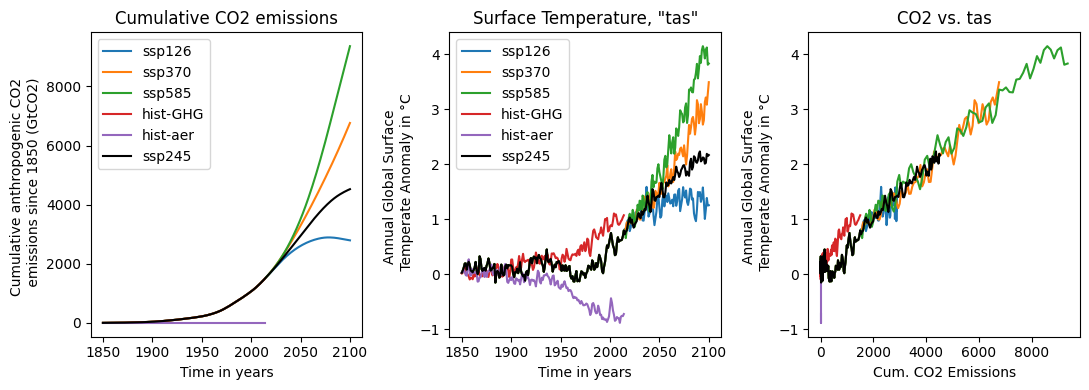

In [12]:
%reload_ext autoreload
%aimport emcli

import emcli.utils.plotting as plotting
from emcli.dataset.climatebench import DATA_VAR_LABELS 
data_var = 'tas'
plotting.plot_co2_data_var_global_over_time(X_train=X_train,
          X_test=X_test, 
          Y_train=Y_train, 
          Y_test=Y_test,
          scenarios_train=scenarios_train,
          scenarios_test=scenarios_test,
          data_var=data_var,
          data_var_labels=DATA_VAR_LABELS);

In [16]:
# Calculate basic statistics 
from emcli.dataset.climatebench import compute_mean_std_X_train
# optionally normalize: from emcli.dataset.climatebench import normalize_data_arr

# Compute mean and standard deviations of each input variable
meanstd_inputs = {}
for var in ['CO2']:
    meanstd_inputs[var] = compute_mean_std_X_train(data_arr = X_train, var=var)

print('Mean and standard deviations:')
[print('\t' + key + ' train mean, std: \t', meanstd_inputs[key]) for key in meanstd_inputs];

Mean and standard deviations:
	CO2 train mean, std: 	 (1074.172303244536, 1755.690699230666)


<a name="methodology"></a>
# Methodology

Currently, some of the best models for achieving our goal are Convolutional Neural Networks (CNN) and Random Forests (RF). These emulators can predict annual mean global distributions of temperature and precipitation given the wide range of emissions and concentrations of carbon dioxide, methane, and aerosols (Watson-Parris et al., 2022). While neural networks scale well, they build representations from spatially close regions of the input, leading to a spatial locality bias (Cachay et al., 2021). Many climate phenomena, though, are driven by global interactions. In contrast, random forests are interpretable, but don’t scale well. The goal is to outperform these models by being both  faster and more precise. Thus, in this tutorial, we will specifically look at ClimateBench’s RF and CNN models as baselines to compare our results.

- **Time-instant mapping** predicts a global surface temperature field at a given year from a global-average CO2 concentration in the same year. This resembles a boundary condition problem.
-	**Autoregressive model** incrementally predicts the global surface temperature field of a year from the global-average CO2 concentration at that year and a global surface temperatue field of the previous year. This resembles an initial condition model.

## Time-instant models: GHGs(t) -> temperature(t):

- Prediction task:
  - $f_{global}: co2_{global-mean}(t) \in \mathbb{R} \rightarrow tas_{global-mean}(t) \in \mathbb{R}$
  - $f_{local}: tas_{global-mean}(t) \in \mathbb{R} \rightarrow tas_{0:lat, 0:lon}(t) \in \mathbb{R}^{(lat, lon)}$
- Models:
  - Linear Pattern Scaling: 
    - $f_{global}$ is linear regression,
    - $f_{local}$ is linear pattern scaling, i.e., one linear regression model per grid cell
  - Polynomial Pattern Scaling: 
    - $f_{global}$ is linear regression,
    - $f_{local}$ is polynomial model per grid cell
- Issues:
  - No memory. Instant quadrupling of CO2 will result in instant temperature quadrupling.
  - Averages over variation of other featues (CH4, SO2, BC)

### Time-instant, myopic models

#### Linear time-instant: global GHG -> global tas

In [14]:
#@title: fit linear model for global GHGs -> global tas

import emcli.models.pattern_scaling.model as ps
import emcli.dataset.interim_to_processed as i2p

# Convert training data from interim to processed
data_var = 'tas' # 'tas', 'pr'
dir_global_global = data_root + 'interim/global_global/'
input_train, target_train = i2p.interim_to_global_global(
                             X_global_local=X_train,#[:-1], # could leave out hist-aer for training, but didn't really matter
                             Y_global_local=Y_train,# [:-1],
                             input_keys=['CO2'],
                             target_keys=[data_var],
                             save_dir=dir_global_global+'train/')

print(target_train.shape)
# Fit Linear regression model from global ghg at t -> global data_var as t
model_lr = ps.fit_linear_regression_global_global(data_dir=dir_global_global+'train/', plot=False)

# Save model
dir_pattern_scaling = repo_root + 'runs/pattern_scaling/default/models/'
model_name = f'global_co2_to_global_{data_var}.pkl'
ps.save(model_lr, dir=dir_pattern_scaling, filename=model_name)

# Convert test data from interim to processed
input_test, target_test = i2p.interim_to_global_global(X_global_local=X_test, # [X_train[2]],# 
                             Y_global_local=Y_test, # [Y_train[2]],#
                             input_keys=['CO2'],
                             target_keys=[data_var],
                             save_dir=dir_global_global+'test/')

# Load model
# model_lr = ps.load(dir=dir_pattern_scaling, filename=model_name)

# Apply linear regression model on test data
preds_lr = ps.predict_linear_regression_global_global(model_lr, 
            data_dir=dir_global_global+'test/',
            plot=False)

Saving processed data at:  ./data/interim/global_global/train/
(1083, 1, 1, 1)
Saving processed data at:  ./data/interim/global_global/test/


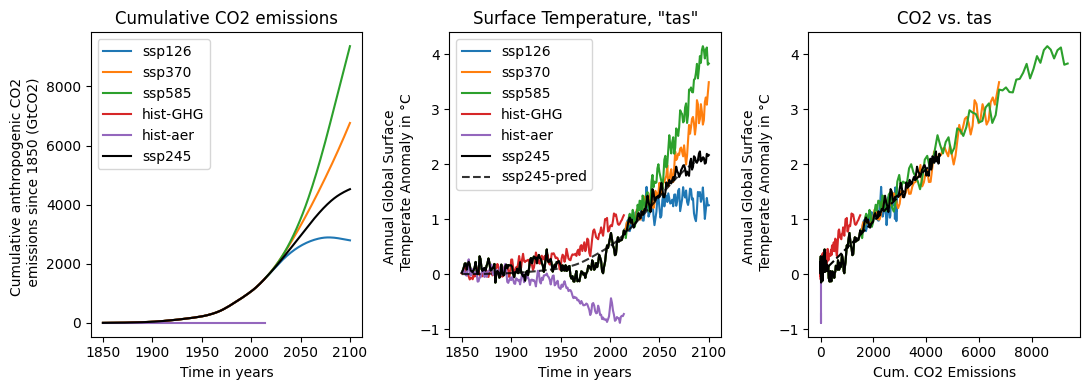

In [15]:
# Plot linear regression predictions

import emcli.utils.plotting as plotting
plotting.plot_co2_data_var_global_over_time(X_train=X_train,
          X_test=X_test, 
          Y_train=Y_train, 
          Y_test=Y_test,
          scenarios_train=scenarios_train,
          scenarios_test=scenarios_test,
          preds=preds_lr,
          data_var=data_var,
          data_var_labels=DATA_VAR_LABELS);

#### Linear pattern scaling: global tas -> local tas

In [16]:
#@title: fit linear pattern scaling model for global tas -> local tas

import emcli
import importlib
importlib.reload(emcli)
#from emcli.models.pattern_scaling.model import PatternScaling
#from emcli.models.pattern_scaling.model import save
import emcli.models.pattern_scaling.model as ps

data_var = 'tas' # 'tas', 'pr', 'pr90'
# Retrieve global temperatures for training
var_global = target_train.flatten() # (n_time,)
# Retrieve annual local temperature field for training
var_local = np.concatenate([dataset[data_var].data for dataset in Y_train],axis=0) # (n_time, n_lat, n_lon)

# Initialize and fit pattern scaling model
pattern_scaling = ps.PatternScaling(deg=1)
pattern_scaling.train(var_global, var_local)

# Save model
dir_pattern_scaling = repo_root + 'runs/pattern_scaling/default/models/'
model_name = f'global_tas_to_local_{data_var}.pkl'
ps.save(pattern_scaling, dir=dir_pattern_scaling,filename=model_name)

# Retrieve test data. Use global tas predictions from previous model as input
var_global_test = preds_lr.flatten() # (n_time,)
# var_global_test = target_test.flatten() # (n_time,) # uncomment to use ground-truth global tas as input

# Load model
# pattern_scaling = ps.load(dir=dir_pattern_scaling)

# Apply pattern scaling model on test data
preds_pattern_scaling = pattern_scaling.predict(var_global_test) # (n_time, n_lat, n_lon)

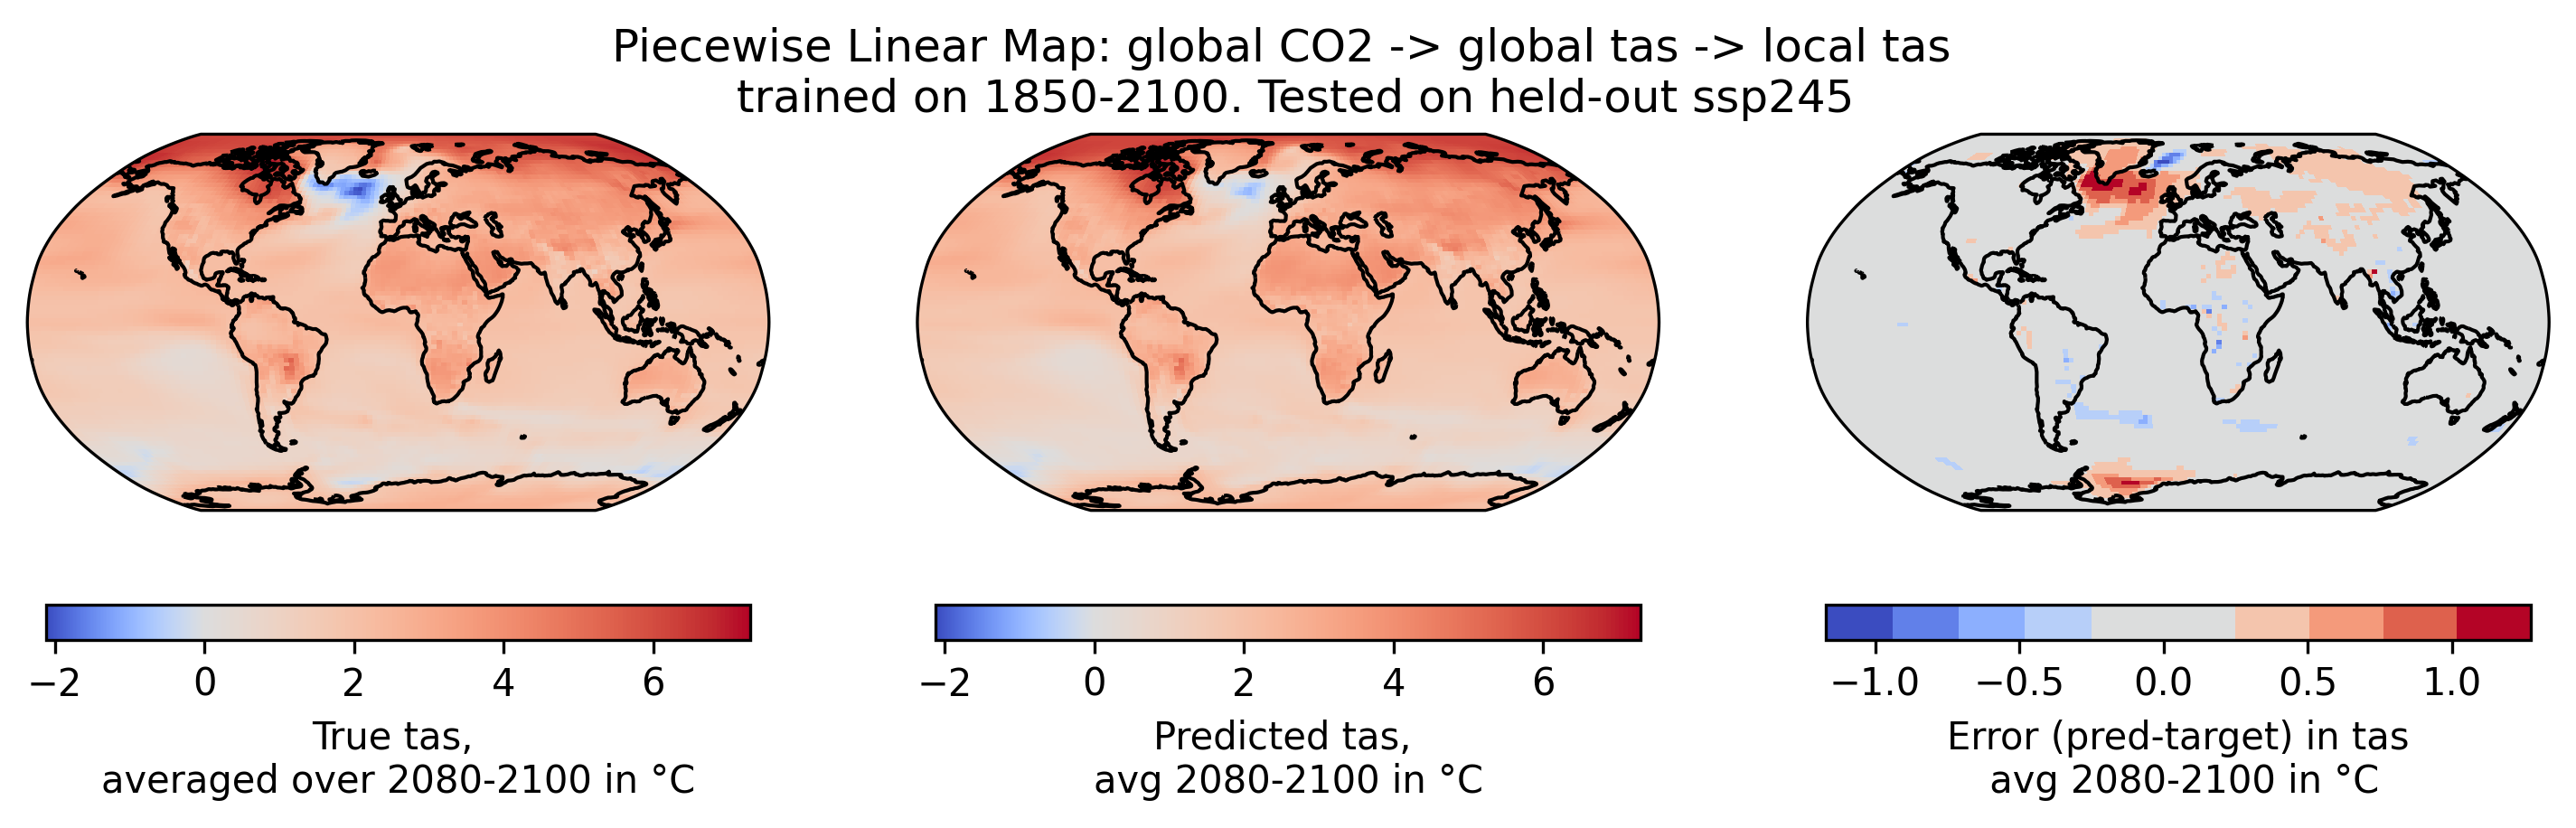

In [17]:
# Plot error map
from emcli.utils.plotting import plot_tas_annual_local_err_map

preds_pattern_scaling_xr = xr.DataArray(data=preds_pattern_scaling, 
    coords=Y_test[0][data_var].coords, name=data_var) # convert predictions into axarray
preds_pattern_scaling_ds = [xr.merge([preds_pattern_scaling_xr])]
axs = plot_tas_annual_local_err_map(Y_test[0][data_var], preds_pattern_scaling_ds[0][data_var], data_var=data_var)
axs[1].set_title(f'Piecewise Linear Map: global CO2 -> global tas -> local {data_var} \n trained on 1850-2100. Tested on held-out {scenarios_test[0]}')
plt.show()

In [18]:
#from xskillscore import rmse
from emcli.utils.metrics import calculate_nrmse

Y_nrmse = calculate_nrmse(Y_true=Y_test[0][data_var], Y_pred=preds_pattern_scaling_ds[0][data_var])
print(Y_nrmse)

0.07969081519021995


#### Polynomial pattern scaling: global tas -> local tas

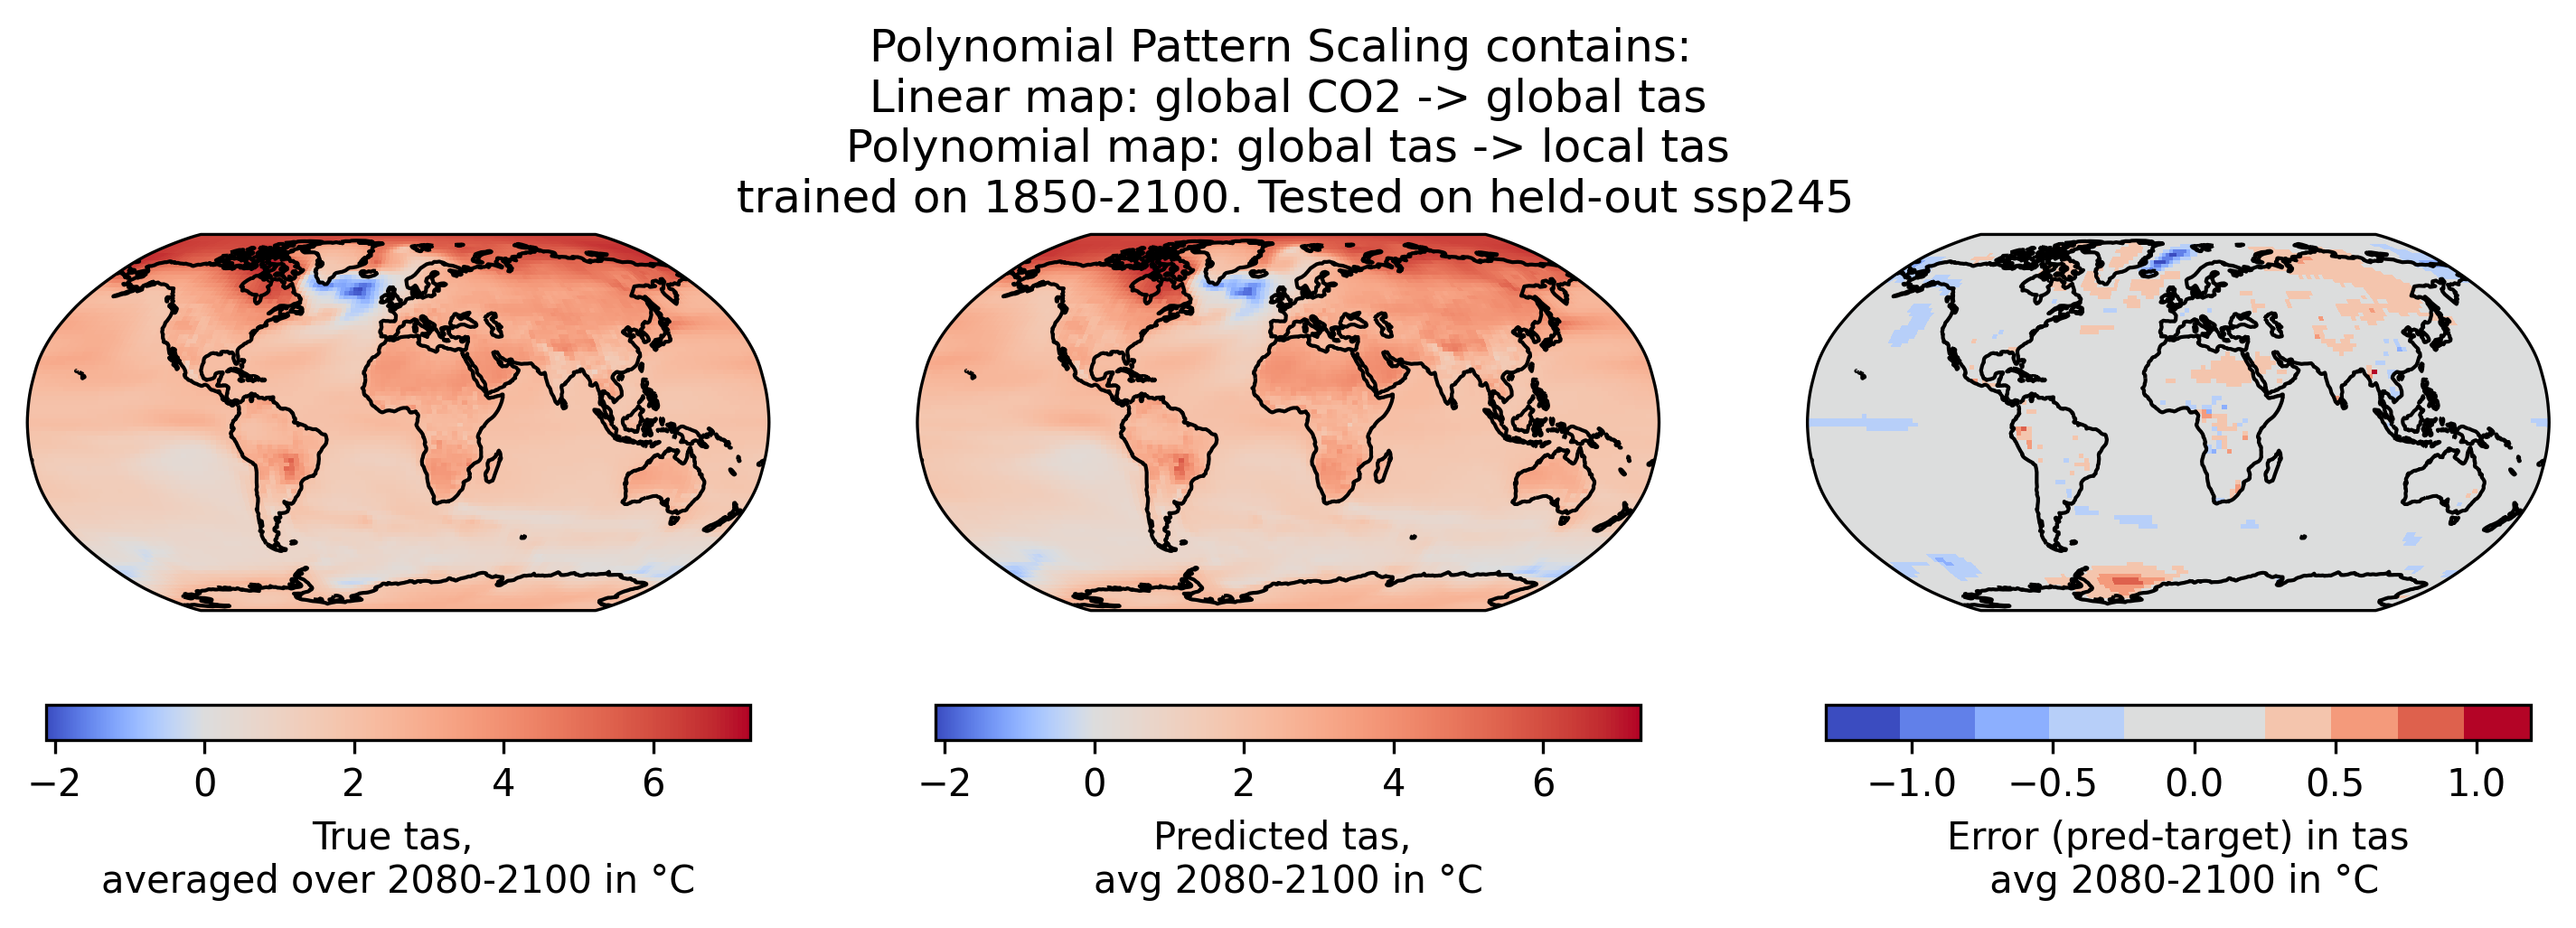

degree:	5:	 NRMSE:0.06827759054693626


In [19]:
# Train polynomial pattern scaling model.
    
degree = 5
pattern_scaling_poly = ps.PatternScaling(deg=degree)
pattern_scaling_poly.train(var_global, var_local)

# Apply pattern scaling model on test data
preds_pattern_scaling_poly = pattern_scaling_poly.predict(var_global_test) # (n_time, n_lat, n_lon)

# Convert into xarray
preds_pattern_scaling_poly_xr = xr.DataArray(data=preds_pattern_scaling_poly, 
    coords=Y_test[0][data_var].coords, name=data_var) # convert predictions into axarray
preds_pattern_scaling_poly_ds = [xr.merge([preds_pattern_scaling_poly_xr])]

# Plot error map
axs = plot_tas_annual_local_err_map(Y_test[0][data_var], preds_pattern_scaling_poly_ds[0][data_var], data_var=data_var)
axs[1].set_title(f'Polynomial Pattern Scaling contains: \n Linear map: global CO2 -> global tas \n Polynomial map: global tas -> local {data_var} \n trained on 1850-2100. Tested on held-out {scenarios_test[0]}')
plt.show()

# Calculate NRMSE
Y_nrmse = calculate_nrmse(Y_true=Y_test[0][data_var], Y_pred=preds_pattern_scaling_poly_ds[0][data_var])
print(f'degree:\t{degree}:\t NRMSE:{Y_nrmse}')

<a name="results-and-discussion"></a>
# Results & Discussion

-	Metrics:
  -	(area weighted) RMSE – blurry, no scale
  - Bias? – measure biases over whole domain (used in precip.)
  - Bias over x-y location
- Temporal forecasting
  -	ACC over forecast time – kind of normalized rmse
-	Baseline models:
  -	Climatology
  -	Linear response surface
  - Compare results with CNN and RF

In [ ]:
# Insert code here. Feel free to break this up into several code
# cells, interleaved with explanatory text.

## Data vs. model complexity. 
Are very large deep learning models necessary or is linear model just fine? Here, we saw that a linear model achieves most of the accuracy. Nevertheless, we learned that the data is not entirely linear. For example, the Arctic is warming faster the more CO2 there is. To find the best model complexity, we're demonstrating a new plot: Model performance vs. model complexity. If the best performing model is one with low complexity we know that our task is likely not very complex or inherently data limited. 

In [39]:
## Find best polynomial degree in nonlinear pattern scaling that fits the data
# Initialize and fit pattern scaling model

from tqdm.notebook import tqdm 

degrees = np.arange(1,23)
Y_nrmse_over_degree = []
for degree in tqdm(degrees):
    pattern_scaling_poly = ps.PatternScaling(deg=degree)
    pattern_scaling_poly.train(tas_global, tas_local)

    # Apply pattern scaling model on test data
    preds_pattern_scaling_poly = pattern_scaling_poly.predict(tas_global_test) # (n_time, n_lat, n_lon)

    # Convert into xarray
    preds_pattern_scaling_poly_xr = xr.DataArray(data=preds_pattern_scaling_poly, 
        coords=Y_test[0]['tas'].coords, name='tas') # convert predictions into axarray
    preds_pattern_scaling_poly_ds = [xr.merge([preds_pattern_scaling_poly_xr])]
    """
    # Plot error map
    axs = plot_tas_annual_local_err_map(Y_test[0]['tas'], preds_pattern_scaling_poly_ds[0]['tas'])
    axs[1].set_title(f'Polynomial Pattern Scaling: global CO2 (linear: ->) global T (polynomial(deg={degree}): ->) local T \n trained on 1850-2100. Tested on held-out {scenarios_test[0]}')
    plt.show()
    """
    # Calculate NRMSE
    Y_nrmse = calculate_nrmse(Y_true=Y_test[0]['tas'], Y_pred=preds_pattern_scaling_poly_ds[0]['tas'])
    Y_nrmse_over_degree.append([degree, Y_nrmse])

Y_nrmse_over_degree = np.transpose(np.array(Y_nrmse_over_degree))

  0%|          | 0/22 [00:00<?, ?it/s]

/mnt/c/Users/Bjoern/code/climate-emulator-tutorial/emcli/models/pattern_scaling/model.py:46: RankWarning: Polyfit may be poorly conditioned
  self.coeffs = np.polyfit(in_global, out_local, deg=self.deg) # (2, n_lat*n_lon)


Text(0.5, 1.0, 'NRMSE over Degree of Polynomial Pattern Scaling:\nLinear: global CO2 -> global T \n Polynomial: global T -> local T \n Trained on 1850-2100.\nTested on 2080-2100 in held-out ssp245')

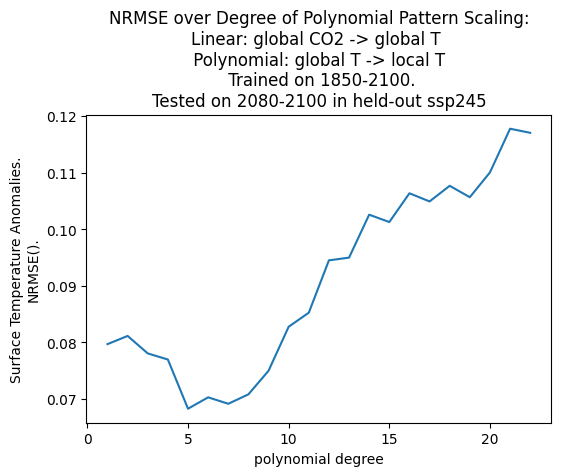

In [40]:
# Plot NRMSE over polynomial degree
fig, axs = plt.subplots(1,1, figsize =(6,4))
axs.plot(Y_nrmse_over_degree[0,:], Y_nrmse_over_degree[1,:])
axs.set_xlabel('polynomial degree')
axs.set_ylabel('Surface Temperature Anomalies.\nNRMSE().')
axs.set_title('NRMSE over polynomial degree. held-out ssp370.')
axs.set_title(f'NRMSE over Degree of Polynomial Pattern Scaling:\nLinear: global CO2 -> global T \n Polynomial: global T -> local T \n Trained on 1850-2100.\nTested on 2080-2100 in held-out {scenarios_test[0]}')

## Limitations:
Models:
- The autoregressive and time-instant model does not model time history. As a result, multi-year patterns, such as ENSO, and seasonal patterns (Winter, Spring, Summer, etc.) are not captured. The seasonal patterns could be captured by taking month as input:
- Monthly time-instant mapping:
  - $[co2_{global-mean}(t), \sin(t_\text{month}), \cos(t_\text{month})] \in \mathbb{R}^3 \rightarrow tas_{0:Lat, 0:Lon}(t) \in \mathbb{R}^{(Lat, Lon)}$
  - $t_\text{month} = \{0°,30°,60°,...330°\}$ for $\{\text{Jan., Feb., ..., Dec.}\}$


Others:

Emulation of the future climate poses particular challenges for machine learning due to the limited amount of training data. Current ML approaches struggle to learn such complex scenarios in small data regimes. As noted earlier, the complex models that are used for modeling are computationally expensive, and there is no information about unseen future scenarios. Furthermore, to build trust in climate emulators for policymakers, model verification is attempted to assert its accuracy objectively. However, this is formally impossible for the Earth, so model evaluation must be completed and relies on underlying physical principles to reassure its broader validity.


In this tutorial, we use a pure ML approach instead of a hybrid physics machine learning. Hybrid physics ML presents a few broader challenges. Most notably, it is challenging to bring together and integrate i.e. statistics, uncertainty quantification, physics, etc. There is also a challenge of balancing the competing demands of hard and soft constraints to develop a model that accurately captures the physics while also being flexible enough to capture the complexities of the problem. This requires careful consideration of the underlying physics and expertise in ML techniques and optimization methods.

Lastly, when it comes to uncertainty quantification, estimating the model (epistemic) and data (aleatoric) uncertainty in and with ML models, respectively, is still an open research field. However, addressing these challenges is crucial to improving the usefulness, reliability, and trust of ML emulators, particularly in an application like this where accurate climate risks, such as likelihood of freezing days in March, number of heat days, distribution over storm surge heights, etc., are critical for decision-makers to enact adequate climate adaptation and mitigation measures.

## Next Steps:
This tutorial only gives a short insight into machine learning in climate science. There exist many outstanding challenges and we refer to some here:

- Other models:
  - end-to-end emulator: init temp + global co2 over time -> temp at 2030
- Other metrics:
  -	Extremes:
    - plot probability distribution of temp.
  -	Response surfaces:
    -	global co2 -> global temp., co2 -> boston temp., co2 -> beijing temp, etc.
-	Common Issues:
 -	Dataset size, CPU vs. GPU
-	Open Challenges:
 -	Extreme measurement
 -	Extend to more data via cesm-emulator notebook

*   What do you imagine would be the next steps for your readers after finishing your tutorial?
*   Discuss other potential climate-related applications for the method or tool discussed in the tutorial.
*   Do you know of other climate-related datasets similar to the one used in this tutorial? List them here.

### All globally-averaged data variables

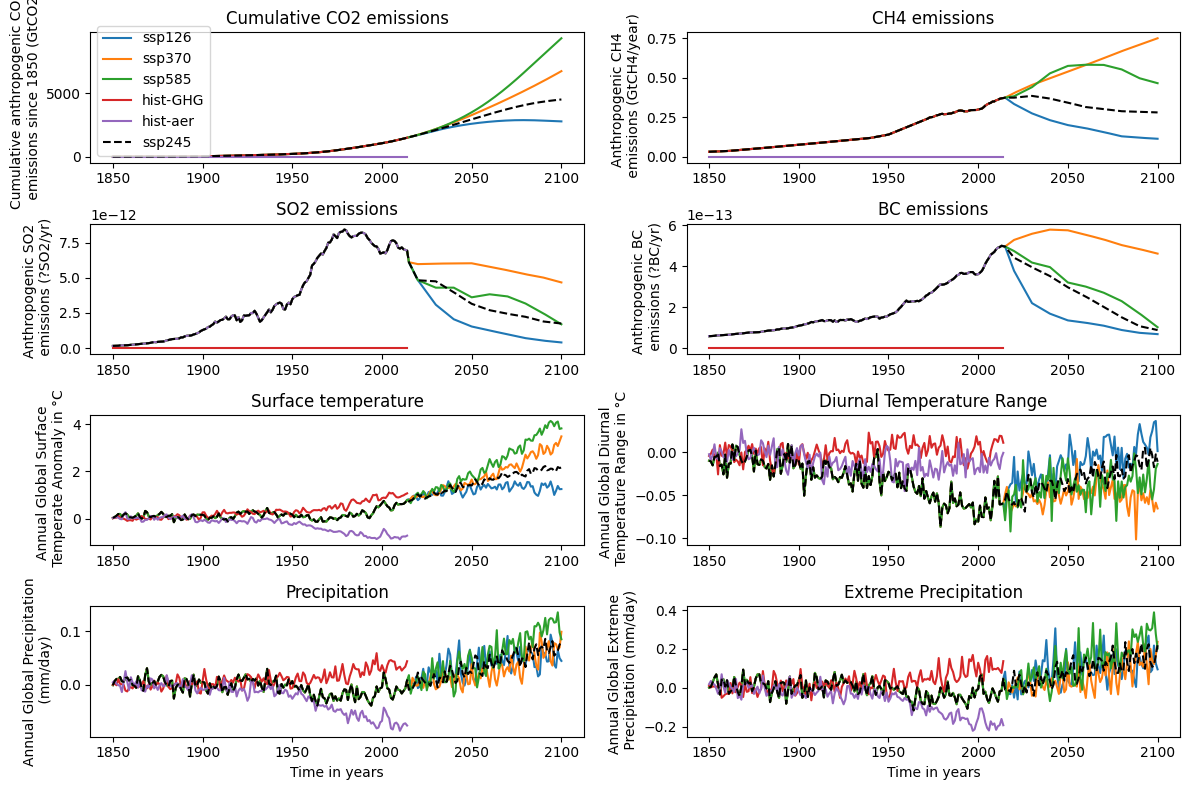

In [13]:
import emcli.utils.plotting as plotting

axs = plotting.plot_all_vars_global_avg(X_train=X_train, 
            X_test=X_test, 
            Y_train=Y_train, 
            Y_test=Y_test,
            scenarios_train=scenarios_train,
            scenarios_test=scenarios_test)

### todos:
- add video of tutorial presentation.

<a name="references"></a>
# References

Please cite this abstract if you consider this tutorial useful:
```
Lütjens, Björn, Lea M. Hadzic, Dava Newman, and Mark Veillette. "The Climate Pocket: Tutorial on Building Fast Emulators in Climate Modeling." AGU23 (2023). online: https://agu.confex.com/agu/fm23/meetingapp.cgi/Paper/1304372
```

Other References

*   Cachay, R. et al. (2021). The World as a Graph: Improving El Niño Forecasts with Graph Neural Networks. https://doi.org/10.48550/arXiv.2104.05089.


*   Millar, R. et al. (2017). Emission budgets and pathways consistent with limiting warming to 1.5 °C. Nature Geoscience, 10, 741–747, https://doi.org/10.1038/ngeo3031.


*   O'Neill, B. C. et al. (2022). The Scenario Model Intercomparison Project (ScenarioMIP) for CMIP6. Geosci. Model Dev., 9, 3461–3482, https://doi.org/10.5194/gmd-9-3461-2016.


*   Pathak et al. (2022). FourCastNet: A Global Data-Driven High-Resolution Weather Model Using Adaptive Fourier Neural Operators. https://doi.org/10.48550/arXiv.2202.11214.


*   Watson-Parris, D. et al. (2022). ClimateBench v1.0: A Benchmark for Data-Driven Climate Projections. Journal of Advances in Modeling Systems, 14(10), https://doi.org/10.1029/2021MS002954.

